In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from rdkit.Chem import PandasTools
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans, DBSCAN
from factor_analyzer.rotator import Rotator
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Data processing
The non-numeric values are removed (ligand name) and the data is normalized. If a parameter is `None` it is replaced by the mean of the column (does not happen a lot).

In [2]:
file_path = "parameters_phd.csv"
data = pd.read_csv(file_path)

ligand_column = data['ligand']
data_numeric = data.drop(columns=['ligand'])
data_numeric = data_numeric.fillna(data_numeric.mean())

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# PCA optimization
The cumulative explained variance and Scree plot for components that explain > 80 % variance combined are generated. It is found that the number is 13 PC.

np.int64(13)

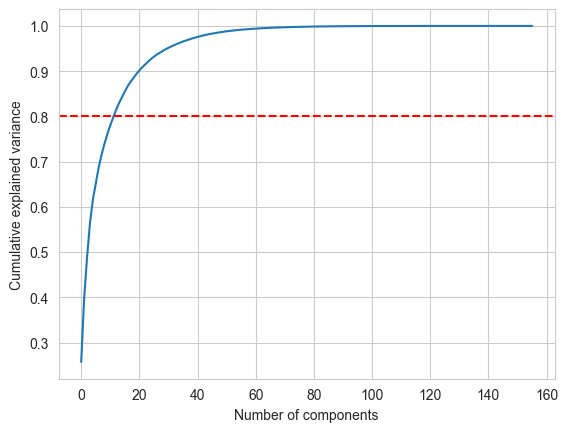

In [3]:
pca = PCA().fit(data_scaled)
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance Threshold')
num_components_geometric = np.argmax(cumsum_variance >= 0.80) + 1
num_components_geometric

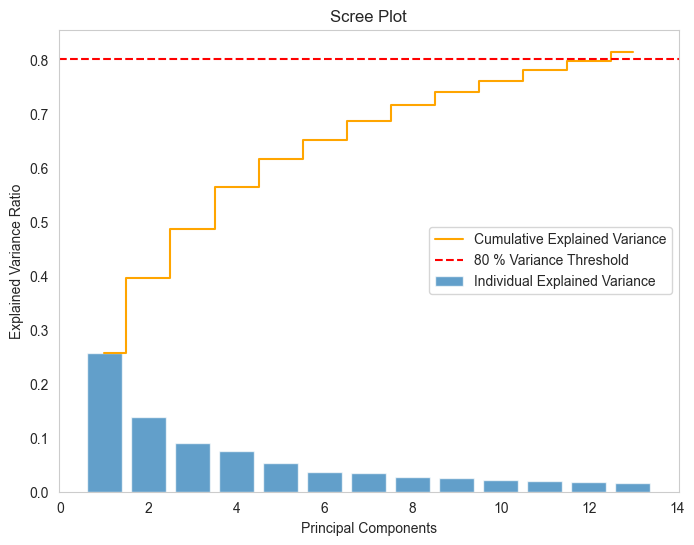

In [4]:
pca = PCA(n_components=13).fit(data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Individual Explained Variance')
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', label='Cumulative Explained Variance', color='orange')
plt.axhline(y=0.8, color='r', linestyle='--', label='80 % Variance Threshold')

plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.grid()
plt.show()

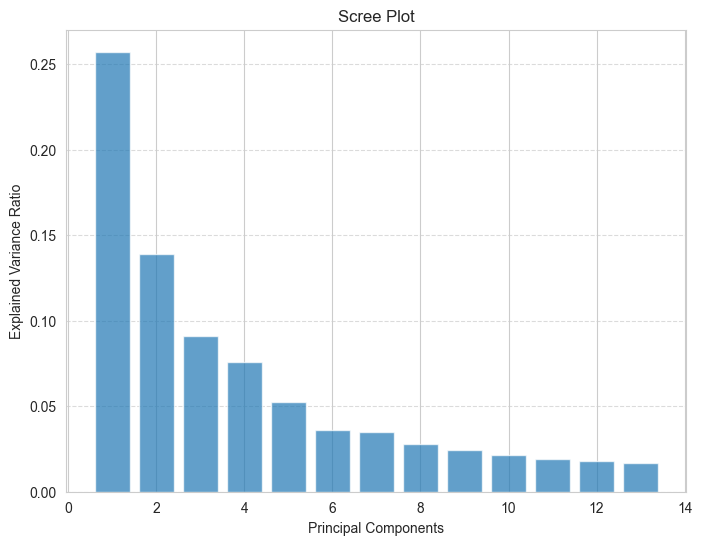

In [5]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')

plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Parameter analysis
The loadings of the PC are analyzed and rotated using varimax to see what parameters explain the most variance for each PC. Interestingly, we can see that among the top 5 parameters in the first two PC we can find electronic, geometric, and steric parameters, highlighting the importance of the three aspects in order to explain the variance of the dataset.

In [6]:
feature_names = [col for col in data.columns if col != 'ligand']

loadings_geometric = pd.DataFrame(
    pca.components_,
    columns=feature_names,  # Feature names
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)
loadings_geometric

,homo,lumo,dipole,rh_charge,rh_LP_1_occ,rh_LP_1_eng,rh_LP_2_occ,rh_LP_2_eng,rh_LP_3_occ,rh_LP_3_eng,...,Vbur%_5.0,NE_5.0,NW_5.0,SE_5.0,SW_5.0,Vbur%_6.0,NE_6.0,NW_6.0,SE_6.0,SW_6.0
PC1,0.055767,0.060926,-0.023633,0.145979,0.034466,0.069478,0.129553,0.083799,-0.108816,0.072795,...,0.055527,0.048519,0.028543,0.070282,0.028186,0.038739,0.036590,0.021308,0.047350,0.021175
PC2,0.145809,0.116198,-0.032833,0.024838,-0.039741,0.137602,0.011498,0.145445,-0.029519,0.146868,...,0.138820,0.083814,0.107914,0.107491,0.129997,0.162025,0.119242,0.126176,0.137423,0.145764
PC3,-0.055010,-0.052451,0.055783,0.061857,-0.000556,-0.062704,0.023647,-0.056641,0.073340,-0.043002,...,0.161210,0.156787,0.130939,0.107899,0.108430,0.130769,0.123138,0.108161,0.093139,0.103138
PC4,0.076291,0.131577,-0.084328,0.007779,0.077818,0.098660,0.107086,0.079246,-0.089327,0.094412,...,0.011401,-0.007012,0.046744,-0.030690,0.022162,-0.008672,-0.032065,0.039691,-0.049148,0.013098
PC5,-0.042148,0.053461,0.014066,0.005087,0.034206,-0.039955,0.000581,-0.013160,-0.003919,-0.017070,...,0.015348,0.012907,-0.014996,-0.006379,0.053648,-0.011772,-0.008715,-0.037495,-0.030881,0.038865
PC6,0.052912,0.023443,-0.019310,-0.002822,0.068668,0.047749,0.022184,0.040521,0.077408,0.018869,...,-0.029286,0.035625,-0.188209,-0.034182,0.095491,-0.044521,0.025738,-0.172462,-0.073321,0.076512
PC7,-0.078876,-0.084214,-0.005248,0.022787,0.023063,-0.077163,0.019352,-0.055446,-0.021763,-0.066593,...,0.011086,-0.147073,-0.065767,0.174213,0.067849,-0.007088,-0.140932,-0.048811,0.118965,0.042472
PC8,0.001787,-0.056778,0.065920,0.044849,0.044446,-0.006499,-0.012613,0.011979,0.006912,-0.000402,...,-0.077085,0.012499,-0.050279,-0.018472,-0.170843,-0.078702,-0.038529,-0.042271,-0.043046,-0.132624
PC9,-0.007332,0.004268,-0.153957,-0.019763,-0.127474,-0.002528,-0.038088,0.077987,0.026190,0.066878,...,0.014731,0.072960,0.002781,0.004395,-0.028002,0.001048,0.024527,0.005990,-0.019971,-0.006238
PC10,-0.043021,-0.015223,0.046813,-0.030917,-0.156994,-0.086745,0.059512,-0.054021,0.185004,-0.088517,...,0.019917,0.011773,0.032403,-0.021663,0.036111,-0.026527,-0.040996,0.000507,-0.063982,0.017857


In [7]:
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(loadings_geometric.values)

# Create a DataFrame for rotated loadings_geometric
rotated_loadings_df = pd.DataFrame(
    rotated_loadings,
    columns=loadings_geometric.columns,
    index=loadings_geometric.index
)
rotated_loadings_df

,homo,lumo,dipole,rh_charge,rh_LP_1_occ,rh_LP_1_eng,rh_LP_2_occ,rh_LP_2_eng,rh_LP_3_occ,rh_LP_3_eng,...,Vbur%_5.0,NE_5.0,NW_5.0,SE_5.0,SW_5.0,Vbur%_6.0,NE_6.0,NW_6.0,SE_6.0,SW_6.0
PC1,-2.226083e-18,6.167637e-17,-4.352034e-18,1.000000e+00,2.610913e-18,-9.154837e-17,1.553193e-16,6.401420e-17,1.701779e-16,-9.167371e-17,...,4.860078e-12,1.135796e-17,-3.126603e-17,3.626447e-17,-2.790637e-17,3.153743e-12,7.632783e-17,-2.775558e-17,-1.318390e-16,1.734723e-17
PC2,6.441006e-16,1.862775e-16,-1.133770e-16,-3.153857e-12,-2.913040e-17,1.072156e-16,2.063603e-16,3.009917e-17,1.586541e-16,-1.707974e-17,...,6.317431e-11,-4.662449e-17,-2.049652e-17,5.101920e-17,-1.182857e-17,1.000000e+00,8.326673e-17,0.000000e+00,-3.469447e-17,-1.387779e-17
PC3,1.320487e-16,-2.114586e-16,-1.650673e-16,-4.860354e-12,-1.230232e-16,3.159535e-17,-7.932256e-17,2.984560e-17,-8.771239e-17,2.560062e-17,...,1.000000e+00,4.057497e-17,5.803721e-17,-3.742108e-17,3.485432e-18,-6.317420e-11,4.163336e-17,1.387779e-17,0.000000e+00,-3.122502e-17
PC4,1.340226e-16,5.458875e-17,5.627061e-18,1.801859e-11,1.747068e-16,6.067537e-17,9.236064e-17,8.838283e-17,-7.068342e-17,3.017067e-17,...,-4.110175e-12,7.709095e-17,1.248168e-16,3.616344e-17,-1.453637e-17,1.167716e-12,-6.938894e-17,-6.938894e-18,6.938894e-17,1.387779e-17
PC5,8.360588e-17,1.673097e-17,-9.614253e-17,3.795256e-12,1.228917e-16,1.041646e-18,8.021726e-17,-1.188545e-16,1.251156e-17,-9.602180e-17,...,-1.351306e-12,-1.239942e-16,-4.492530e-17,-8.839175e-18,-1.235705e-17,-9.629451e-12,5.551115e-17,3.469447e-18,-3.469447e-17,0.000000e+00
PC6,-1.504413e-17,1.035317e-16,-5.422588e-17,4.150087e-11,-1.477113e-16,7.232075e-17,-3.035450e-16,1.601104e-16,2.571976e-16,4.138315e-19,...,7.696638e-12,4.218655e-17,-3.467362e-17,-5.397956e-17,-1.849958e-17,8.941350e-12,-3.469447e-18,-7.632783e-17,3.122502e-17,7.632783e-17
PC7,3.976892e-16,-3.870425e-17,-4.191163e-17,-3.571046e-11,5.441618e-18,-1.900006e-18,-5.187025e-17,8.288046e-18,-2.113295e-17,1.772560e-16,...,2.997655e-12,2.740481e-17,-1.489362e-17,6.162487e-17,-1.514725e-18,-5.404568e-12,-2.081668e-17,-2.428613e-17,-2.428613e-17,3.469447e-18
PC8,-4.429360e-16,4.944801e-17,-1.022902e-16,-1.108658e-11,-1.244233e-17,2.778571e-17,-1.845057e-16,1.994627e-16,1.316459e-16,1.708350e-16,...,-3.669589e-13,-9.691533e-19,1.431973e-17,6.664619e-17,5.394234e-17,-1.128986e-11,-1.387779e-17,2.428613e-17,-1.110223e-16,3.122502e-17
PC9,-1.474041e-16,1.871493e-17,-3.750064e-17,2.570397e-11,4.097566e-17,-4.517863e-17,3.265141e-17,-2.280680e-16,1.066528e-16,4.772354e-17,...,8.760983e-12,1.167196e-17,-1.961694e-17,3.335415e-17,6.140260e-18,-5.411032e-12,3.469447e-17,-5.204170e-17,-6.938894e-17,-2.081668e-17
PC10,-1.836660e-17,-9.837092e-17,1.782809e-16,5.698484e-12,9.429382e-17,1.298107e-17,5.564817e-18,3.023077e-17,-6.111649e-18,-1.361025e-16,...,5.721179e-12,-7.598459e-17,-1.103429e-16,-3.070954e-17,5.014070e-18,-6.030216e-12,-6.938894e-17,0.000000e+00,-2.428613e-17,-1.387779e-17


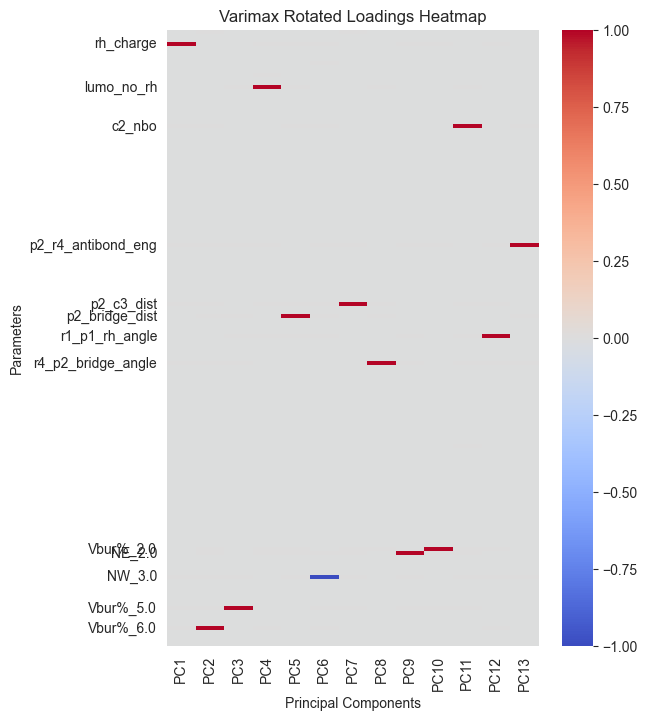

In [8]:
rotated_loadings = rotated_loadings_df.values
param_names = rotated_loadings_df.columns

# Define a threshold for "relevance" to display the names of the parameters in the y axis
threshold = 0.4
max_loadings = np.max(np.abs(rotated_loadings), axis=0)

# Keep parameter names only if at least one loading exceeds the threshold
relevant_params = [name if max_loadings[i] > threshold else "" for i, name in enumerate(param_names)]

rotated_loadings_T = rotated_loadings.T

plt.figure(figsize=(6, 8))
sns.heatmap(rotated_loadings_T, cmap='coolwarm', center=0, annot=False,
            xticklabels=[f'PC{i+1}' for i in range(13)], yticklabels=relevant_params)

# Formatting
plt.xlabel('Principal Components')
plt.ylabel('Parameters')
plt.title('Varimax Rotated Loadings Heatmap')
plt.show()

In [9]:
# Extract the most relevant features for each factor
top_n = 5  # Number of top features to select per factor
most_relevant_features = {}

for factor in rotated_loadings_df.index:
    # Get top N features by absolute loading
    top_features = rotated_loadings_df.loc[factor].abs().nlargest(top_n).index.tolist()
    most_relevant_features[factor] = top_features

# Display results
for factor, features in most_relevant_features.items():
    print(f"{factor}: {features}")

PC1: ['rh_charge', 'NW_3.0', 'p2_c3_dist', 'NE_2.0', 'lumo_no_rh']
PC2: ['Vbur%_6.0', 'Vbur%_5.0', 'c2_nbo', 'r4_p2_bridge_angle', 'p2_bridge_dist']
PC3: ['Vbur%_5.0', 'Vbur%_6.0', 'c2_nbo', 'p2_r4_antibond_eng', 'NE_2.0']
PC4: ['lumo_no_rh', 'rh_charge', 'NW_3.0', 'p2_c3_dist', 'r4_p2_bridge_angle']
PC5: ['p2_bridge_dist', 'Vbur%_6.0', 'lumo_no_rh', 'rh_charge', 'p2_c3_dist']
PC6: ['NW_3.0', 'p2_c3_dist', 'c2_nbo', 'rh_charge', 'NE_2.0']
PC7: ['p2_c3_dist', 'NW_3.0', 'rh_charge', 'c2_nbo', 'lumo_no_rh']
PC8: ['r4_p2_bridge_angle', 'NE_2.0', 'Vbur%_6.0', 'rh_charge', 'lumo_no_rh']
PC9: ['NE_2.0', 'r4_p2_bridge_angle', 'rh_charge', 'NW_3.0', 'p2_r4_antibond_eng']
PC10: ['Vbur%_2.0', 'Vbur%_6.0', 'Vbur%_5.0', 'rh_charge', 'lumo_no_rh']
PC11: ['c2_nbo', 'NW_3.0', 'Vbur%_5.0', 'p2_c3_dist', 'Vbur%_6.0']
PC12: ['r1_p1_rh_angle', 'Vbur%_5.0', 'c2_nbo', 'NE_2.0', 'p2_r4_antibond_eng']
PC13: ['p2_r4_antibond_eng', 'Vbur%_5.0', 'rh_charge', 'NE_2.0', 'c2_nbo']


## PCA plot
3D plot classifing the ligands by the type of bridge. No significant clusters can be distinguished in this way. Interactive 3D and 2D plots with plotly are also available.

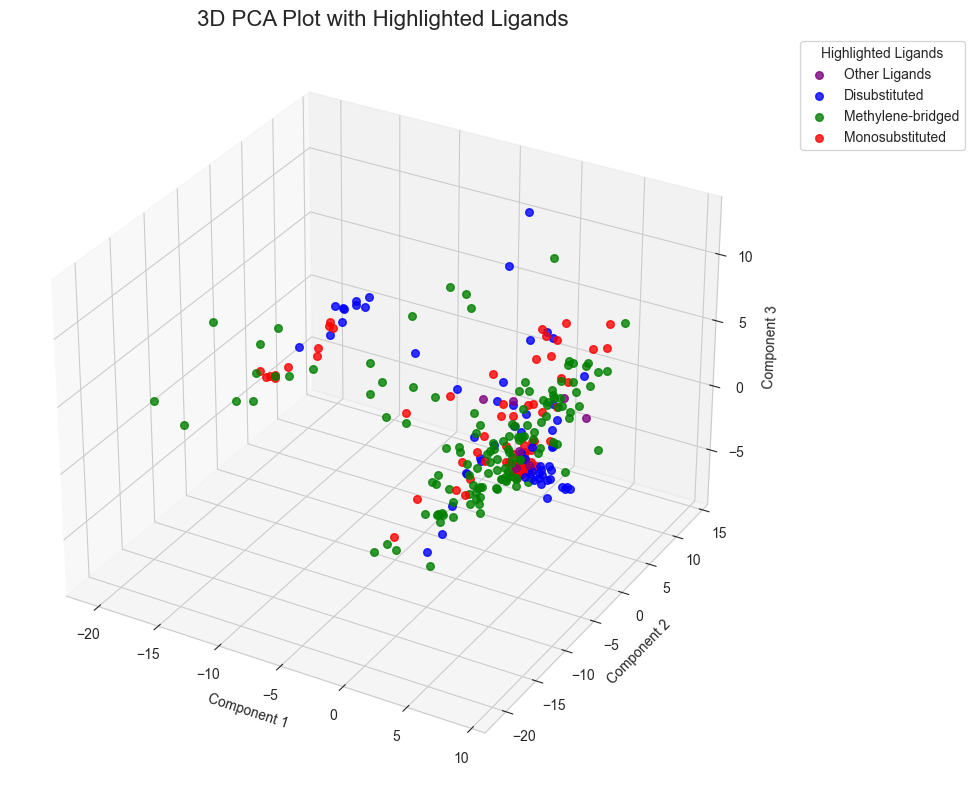

In [10]:
pca_df = pd.DataFrame(pca.transform(data_scaled))
pca_df['ligand'] = ligand_column.values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

categories = {
    "DS": {"color": "blue", "label": "Disubstituted"},
    "MS": {"color": "red", "label": "Monosubstituted"},
    "MB": {"color": "green", "label": "Methylene-bridged"},
    "Other": {"color": "purple", "label": "Other Ligands"},
}
labels_added = {key: False for key in categories}

for ligand in pca_df['ligand'].unique():
    subset = pca_df[pca_df['ligand'] == ligand]
    if "DS" in ligand:
        category = "DS"
    elif "MS" in ligand:
        category = "MS"
    elif "MB" in ligand:
        category = "MB"
    else:
        category = "Other"

    ax.scatter(
        subset[0],
        subset[1],
        subset[2],
        color=categories[category]["color"],
        s=30,
        alpha=0.8,
        label=categories[category]["label"] if not labels_added[category] else None
    )
    labels_added[category] = True

ax.set_title('3D PCA Plot with Highlighted Ligands', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend(title='Highlighted Ligands', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
# Dictionary for ligand categories and their colors
categories = {
    "DS": {"color": "blue", "label": "DS Ligands"},
    "MS": {"color": "red", "label": "MS Ligands"},
    "MB": {"color": "green", "label": "MB Ligands"},
    "Other": {"color": "purple", "label": "Other Ligands"},
}

# Initialize a Plotly figure
fig = go.Figure()

# Add scatter traces for each category
for category, properties in categories.items():
    subset = pca_df[
        pca_df['ligand'].str.contains(category) if category != "Other" else ~pca_df['ligand'].str.contains("DS|MS|MB")
    ]
    fig.add_trace(
        go.Scatter3d(
            x=subset['Component 1'],
            y=subset['Component 2'],
            z=subset['Component 3'],
            mode='markers',
            marker=dict(size=5, color=properties["color"]),
            name=properties["label"],  # Legend label
            text=subset['ligand'],  # Hover text
            hoverinfo="text"  # Display only hover text
        )
    )

# Customize layout
fig.update_layout(
    title='3D PCA Plot with Highlighted Ligands',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    legend=dict(title="Ligand Categories")
)

# Show plot
fig.show()

KeyError: 'Component 1'

In [ ]:

# Dictionary for ligand categories and their colors
categories = {
    "DS": {"color": "blue", "label": "DS Ligands"},
    "MS": {"color": "red", "label": "MS Ligands"},
    "MB": {"color": "green", "label": "MB Ligands"},
    "Other": {"color": "purple", "label": "Other Ligands"},
}

# Assign a category to each ligand for color coding
def get_category(ligand):
    if "DS" in ligand:
        return "DS Ligands"
    elif "MS" in ligand:
        return "MS Ligands"
    elif "MB" in ligand:
        return "MB Ligands"
    else:
        return "Other Ligands"

pca_df['category'] = pca_df['ligand'].apply(get_category)

# Define a function to plot 2D slices
def plot_2d_slice(x, y, x_label, y_label):
    fig = px.scatter(
        pca_df,
        x=x,
        y=y,
        color='category',
        color_discrete_map={
            "DS Ligands": "blue",
            "MS Ligands": "red",
            "MB Ligands": "green",
            "Other Ligands": "purple",
        },
        hover_data={'ligand': True},  # Show ligand names on hover
        title=f'2D PCA Slice: {x_label} vs {y_label}',
        labels={'category': 'Ligand Category'}
    )
    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        legend_title="Ligand Categories"
    )
    return fig

# Generate and display 2D slices
fig1 = plot_2d_slice('Component 1', 'Component 2', 'Component 1', 'Component 2')
fig2 = plot_2d_slice('Component 1', 'Component 3', 'Component 1', 'Component 3')
fig3 = plot_2d_slice('Component 2', 'Component 3', 'Component 2', 'Component 3')

# Show the figures
fig1.show()
fig2.show()
fig3.show()

## Component separation
In this approach all parameters are classified into geometric, electronic, or steric. This is different to what Sigman does, where they choose certain parameters over others without a rational explanation.
In out case, we perform three PCAs, one for each set of parameters, and define the first PC of each as the axis of the 3D plot that represents chemical space.
One interesting idea (I think) would be to apply varimax rotation on each PCA to determine the most important factors on the first PCs, in order to reduce the number of initial parameters from which the three PCAs are constructed. However, I don't know if doing this would provide any significant improvement.

In [39]:
geometric = [
	"bite_angle",
	"c1_rh_dist",
	"c2_rh_dist",
	"c3_rh_dist",
	"c4_rh_dist",
	"p1_c1_dist",
	"p1_c2_dist",
	"p2_c3_dist",
	"p2_c4_dist",
	"p1_bridge_dist",
	"p2_bridge_dist",
	"p1_angle_sum",
	"p2_angle_sum",
	"rh_p1_bridge_angle",
	"rh_p2_bridge_angle",
	"r1_p1_rh_angle",
	"r2_p1_rh_angle",
	"r3_p2_rh_angle",
	"r4_p2_rh_angle",
	"r1_p1_bridge_angle",
	"r2_p1_bridge_angle",
	"r3_p2_bridge_angle",
	"r4_p2_bridge_angle"
]

steric = [
	"Vbur%_1.0",
	"NE_1.0",
	"NW_1.0",
	"SE_1.0",
	"SW_1.0",
	"Vbur%_2.0",
	"NE_2.0",
	"NW_2.0",
	"SE_2.0",
	"SW_2.0",
	"Vbur%_3.0",
	"NE_3.0",
	"NW_3.0",
	"SE_3.0",
	"SW_3.0",
	"Vbur%_4.0",
	"NE_4.0",
	"NW_4.0",
	"SE_4.0",
	"SW_4.0",
	"Vbur%_5.0",
	"NE_5.0",
	"NW_5.0",
	"SE_5.0",
	"SW_5.0",
	"Vbur%_6.0",
	"NE_6.0",
	"NW_6.0",
	"SE_6.0",
	"SW_6.0"
]

electronic = [
	"homo",
	"lumo",
	"dipole",
	"rh_charge",
	"rh_LP_1_occ",
	"rh_LP_1_eng",
	"rh_LP_2_occ",
	"rh_LP_2_eng",
	"rh_LP_3_occ",
	"rh_LP_3_eng",
	"rh_LP_4_occ",
	"rh_LP_4_eng",
	"homo_no_rh",
	"lumo_no_rh",
	"dipole_no_rh",
	"r1_nbo",
	"r2_nbo",
	"r3_nbo",
	"r4_nbo",
	"bridge_nbo",
	"p1_nbo",
	"p2_nbo",
	"c1_nbo",
	"c2_nbo",
	"c3_nbo",
	"c4_nbo",
	"p1_nmr",
	"p1_nmr_aniso",
	"p2_nmr",
	"p2_nmr_aniso",
	"p1_rh_bond_occ",
	"p2_rh_bond_occ",
	"p1_rh_bond_eng",
	"p2_rh_bond_eng",
	"p1_rh_antibond_occ",
	"p2_rh_antibond_occ",
	"p1_rh_antibond_eng",
	"p2_rh_antibond_eng",
	"p1_r1_bond_occ",
	"p1_r2_bond_occ",
	"p2_r3_bond_occ",
	"p2_r4_bond_occ",
	"p1_r1_bond_eng",
	"p1_r2_bond_eng",
	"p2_r3_bond_eng",
	"p2_r4_bond_eng",
	"p1_r1_antibond_occ",
	"p1_r2_antibond_occ",
	"p2_r3_antibond_occ",
	"p2_r4_antibond_occ",
	"p1_r1_antibond_eng",
	"p1_r2_antibond_eng",
	"p2_r3_antibond_eng",
	"p2_r4_antibond_eng",
	"p1_bridge_bond_occ",
	"p2_bridge_bond_occ",
	"p1_bridge_bond_eng",
	"p2_bridge_bond_eng",
	"p1_bridge_antibond_occ",
	"p2_bridge_antibond_occ",
	"p1_bridge_antibond_eng",
	"p2_bridge_antibond_eng",
	"p1_nbo_no_rh",
	"p2_nbo_no_rh",
	"r1_nbo_no_rh",
	"r2_nbo_no_rh",
	"r3_nbo_no_rh",
	"r4_nbo_no_rh",
	"bridge_nbo_no_rh",
	"p1_nmr_no_rh",
	"p1_nmr_aniso_no_rh",
	"p2_nmr_no_rh",
	"p2_nmr_aniso_no_rh",
	"p1_LP_occ_no_rh",
	"p1_LP_eng_no_rh",
	"p2_LP_occ_no_rh",
	"p2_LP_eng_no_rh",
	"p1_r1_bond_occ_no_rh",
	"p1_r2_bond_occ_no_rh",
	"p2_r3_bond_occ_no_rh",
	"p2_r4_bond_occ_no_rh",
	"p1_r1_bond_eng_no_rh",
	"p1_r2_bond_eng_no_rh",
	"p2_r3_bond_eng_no_rh",
	"p2_r4_bond_eng_no_rh",
	"p1_r1_antibond_occ_no_rh",
	"p1_r2_antibond_occ_no_rh",
	"p2_r3_antibond_occ_no_rh",
	"p2_r4_antibond_occ_no_rh",
	"p1_r1_antibond_eng_no_rh",
	"p1_r2_antibond_eng_no_rh",
	"p2_r3_antibond_eng_no_rh",
	"p2_r4_antibond_eng_no_rh",
	"p1_bridge_bond_occ_no_rh",
	"p2_bridge_bond_occ_no_rh",
	"p1_bridge_bond_eng_no_rh",
	"p2_bridge_bond_eng_no_rh",
	"p1_bridge_antibond_occ_no_rh",
	"p2_bridge_antibond_occ_no_rh",
	"p1_bridge_antibond_eng_no_rh",
	"p2_bridge_antibond_eng_no_rh",
	"p1_LP_s_occ_no_rh",
	"p2_LP_s_occ_no_rh"
]

data_scaled_name = pd.DataFrame(data_scaled, columns=data_numeric.columns)

Constructs the three PCAs. Varimax rotation is also applied.

[Geometric DataFrame] Removed 0 low-variance features:
[]
[Geometric DataFrame] Removed 0 highly correlated features:
[]
[Electronic DataFrame] Removed 0 low-variance features:
[]
[Electronic DataFrame] Removed 0 highly correlated features:
[]
[Steric DataFrame] Removed 0 low-variance features:
[]
[Steric DataFrame] Removed 2 highly correlated features:
['SW_1.0', 'SE_1.0']


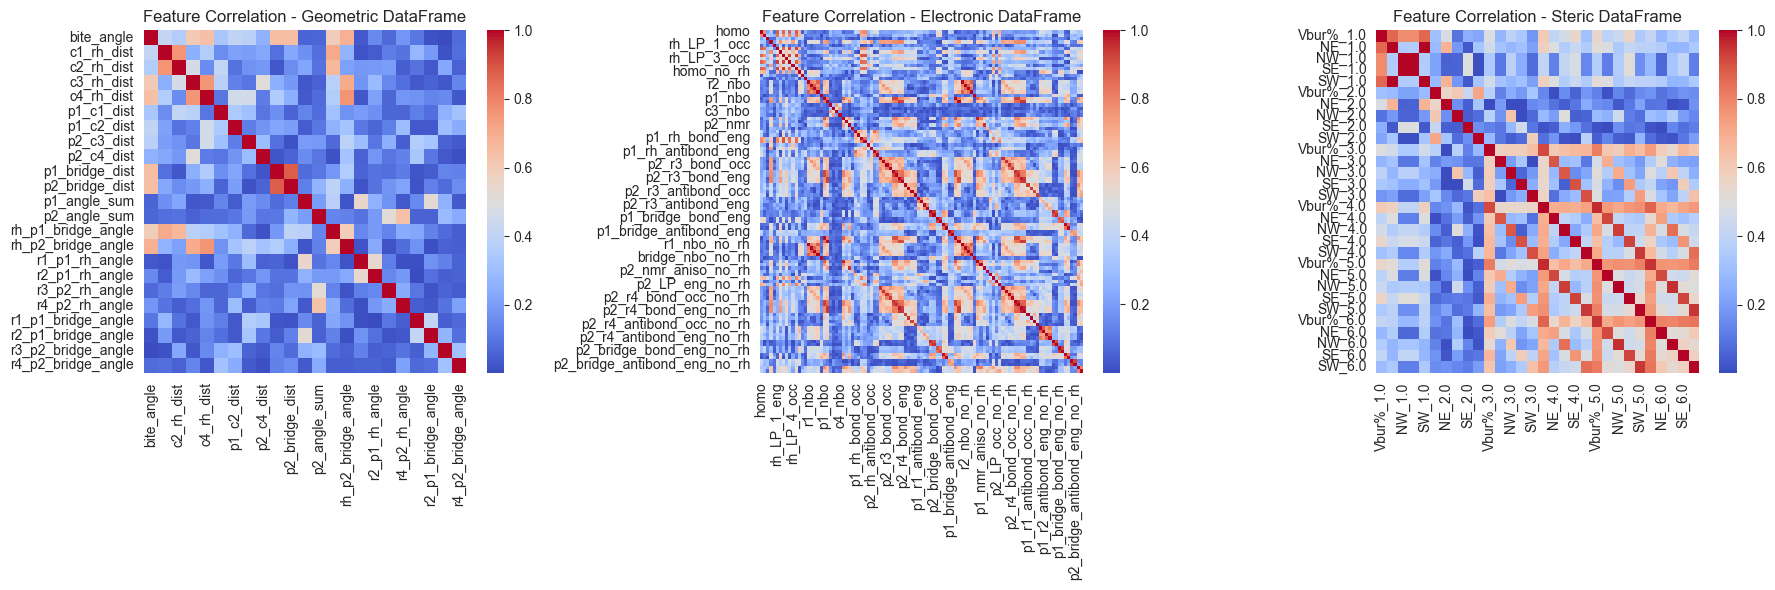

Final shape of Geometric DataFrame: (294, 23)
Final shape of Electronic DataFrame: (294, 103)
Final shape of Steric DataFrame: (294, 28)


In [157]:
def reduce_features(df, name, var_threshold = 0.01, corr_threshold = 0.99):
    """Removes low-variance features and highly correlated features from a DataFrame."""

    ### Step 1: Remove Low-Variance Features ###
    selector = VarianceThreshold(threshold=var_threshold)  # Set variance threshold
    mask = selector.fit(df).get_support()  # Boolean mask of selected features

    # Get removed low-variance features
    removed_low_variance = df.columns[~mask]
    print(f'[{name}] Removed {len(removed_low_variance)} low-variance features:')
    print(removed_low_variance.tolist())

    # Update dataset after removing low-variance features
    df_reduced = df.loc[:, mask]

    ### Step 2: Identify and Remove Highly Correlated Features ###
    corr_matrix = df_reduced.corr().abs()

    # Find pairs of highly correlated features
    highly_correlated_pairs = [
        (col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns
        if col1 != col2 and corr_matrix.loc[col1, col2] > corr_threshold
    ]

    # Drop one feature from each correlated pair
    features_to_drop = set()
    for col1, col2 in highly_correlated_pairs:
        if col1 not in features_to_drop:
            features_to_drop.add(col2)

    df_final = df_reduced.drop(columns=features_to_drop)

    # Print removed highly correlated features
    print(f'[{name}] Removed {len(features_to_drop)} highly correlated features:')
    print(list(features_to_drop))

    return df_final, corr_matrix

geometric_df = data_scaled_name[geometric]
electronic_df = data_scaled_name[electronic]
steric_df = data_scaled_name[steric]

# Apply feature reduction to all three DataFrames
geometric_df_final, corr_geometric = reduce_features(geometric_df, "Geometric DataFrame")
electronic_df_final, corr_electronic = reduce_features(electronic_df, "Electronic DataFrame", corr_threshold=1)
steric_df_final, corr_steric = reduce_features(steric_df, "Steric DataFrame", corr_threshold=0.99)

# Plot all three correlation heatmaps in a single figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(corr_geometric, cmap='coolwarm', ax=axes[0])
axes[0].set_title("Feature Correlation - Geometric DataFrame")

sns.heatmap(corr_electronic, cmap='coolwarm', ax=axes[1])
axes[1].set_title("Feature Correlation - Electronic DataFrame")

sns.heatmap(corr_steric, cmap='coolwarm', ax=axes[2])
axes[2].set_title("Feature Correlation - Steric DataFrame")

plt.tight_layout()
plt.show()

# Print final dataset shapes
print(f'Final shape of Geometric DataFrame: {geometric_df_final.shape}')
print(f'Final shape of Electronic DataFrame: {electronic_df_final.shape}')
print(f'Final shape of Steric DataFrame: {steric_df_final.shape}')

In [158]:
# Create PCAs for each group of parameters. They will have as many components as parameters has the group
pca_geometric = PCA().fit(geometric_df_final)
pca_electronic = PCA().fit(electronic_df_final)
pca_steric = PCA().fit(steric_df_final)

pca_geometric_raw = PCA().fit(data_scaled_name[geometric])
pca_electronic_raw = PCA().fit(data_scaled_name[electronic])
pca_steric_raw = PCA().fit(data_scaled_name[steric])

# Get the number of PC that explain >= 80 % of the variance for each PCA and recalculate PCA with the obtained value
cumsum_variance_geometric = np.cumsum(pca_geometric.explained_variance_ratio_)
num_components_geometric = np.argmax(cumsum_variance_geometric >= 0.80) + 1
pca_geometric = PCA(n_components=num_components_geometric).fit(geometric_df_final)

cumsum_variance_electronic = np.cumsum(pca_electronic.explained_variance_ratio_)
num_components_electronic = np.argmax(cumsum_variance_electronic >= 0.80) + 1
pca_electronic = PCA(n_components=num_components_electronic).fit(electronic_df_final)

cumsum_variance_steric = np.cumsum(pca_steric.explained_variance_ratio_)
num_components_steric = np.argmax(cumsum_variance_steric >= 0.80) + 1
pca_steric = PCA(n_components=num_components_steric).fit(steric_df_final)

cumsum_variance_geometric_raw = np.cumsum(pca_geometric.explained_variance_ratio_)
num_components_geometric_raw = np.argmax(cumsum_variance_geometric >= 0.80) + 1
pca_geometric_raw = PCA(n_components=num_components_geometric).fit(data_scaled_name[geometric])

cumsum_variance_electronic_raw = np.cumsum(pca_electronic.explained_variance_ratio_)
num_components_electronic_raw = np.argmax(cumsum_variance_electronic >= 0.80) + 1
pca_electronic_raw = PCA(n_components=num_components_electronic).fit(data_scaled_name[electronic])

cumsum_variance_steric_raw = np.cumsum(pca_steric.explained_variance_ratio_)
num_components_steric_raw = np.argmax(cumsum_variance_steric >= 0.80) + 1
pca_steric_raw = PCA(n_components=num_components_steric).fit(data_scaled_name[steric])

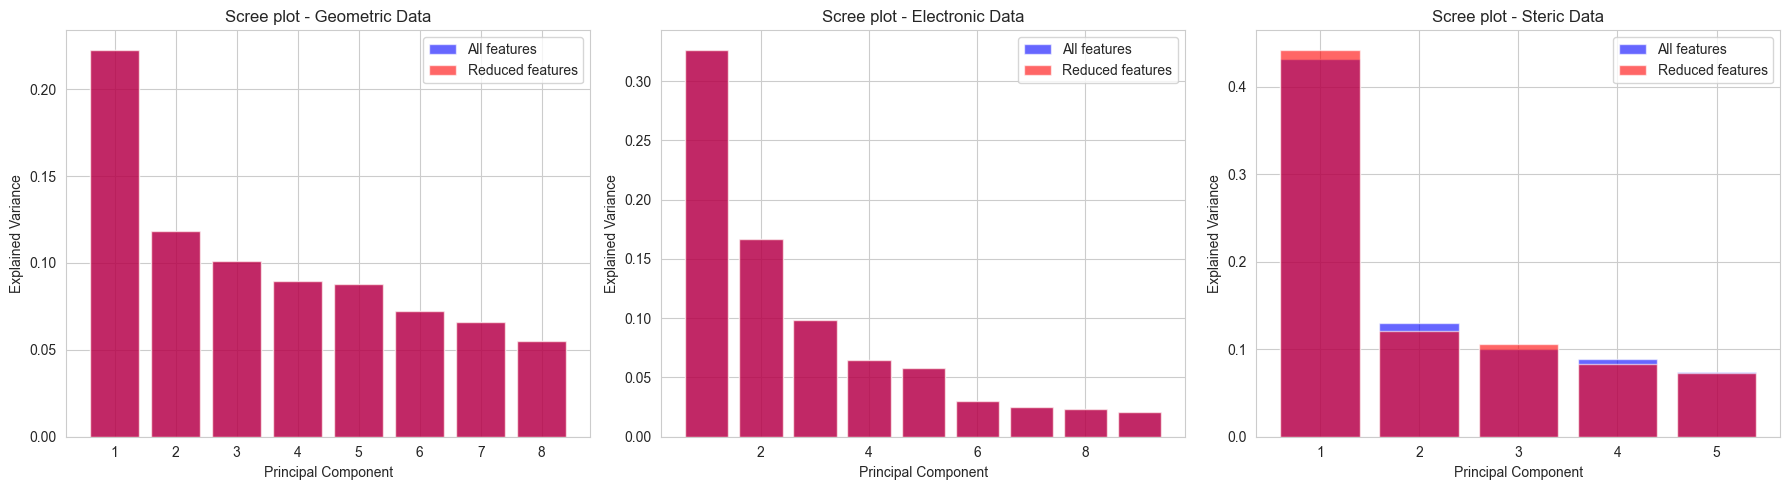

In [159]:
# Function to get explained variance
def get_variance(pca_model):
    return pca_model.explained_variance_ratio_

# Compute explained variance for each PCA
var_geometric = get_variance(pca_geometric)
var_electronic = get_variance(pca_electronic)
var_steric = get_variance(pca_steric)

var_geometric_raw = get_variance(pca_geometric_raw)
var_electronic_raw = get_variance(pca_electronic_raw)
var_steric_raw = get_variance(pca_steric_raw)

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    ("Geometric", var_geometric_raw, var_geometric),
    ("Electronic", var_electronic_raw, var_electronic),
    ("Steric", var_steric_raw, var_steric)
]

for i, (title, raw_variance, reduced_variance) in enumerate(datasets):
    num_pcs_raw = len(raw_variance)
    num_pcs_reduced = len(reduced_variance)

    x_raw = np.arange(1, num_pcs_raw + 1)
    x_reduced = np.arange(1, num_pcs_reduced + 1)

    axes[i].bar(x_raw, raw_variance, alpha=0.6, label="All features", color='blue')
    axes[i].bar(x_reduced, reduced_variance, alpha=0.6, label="Reduced features", color='red')

    axes[i].set_title(f"Scree plot - {title} Data")
    axes[i].set_xlabel("Principal Component")
    axes[i].set_ylabel("Explained Variance")
    axes[i].legend()

plt.tight_layout()
plt.show()


Generates heatmaps for the rotated loadings to see the most important parameters in each PC.

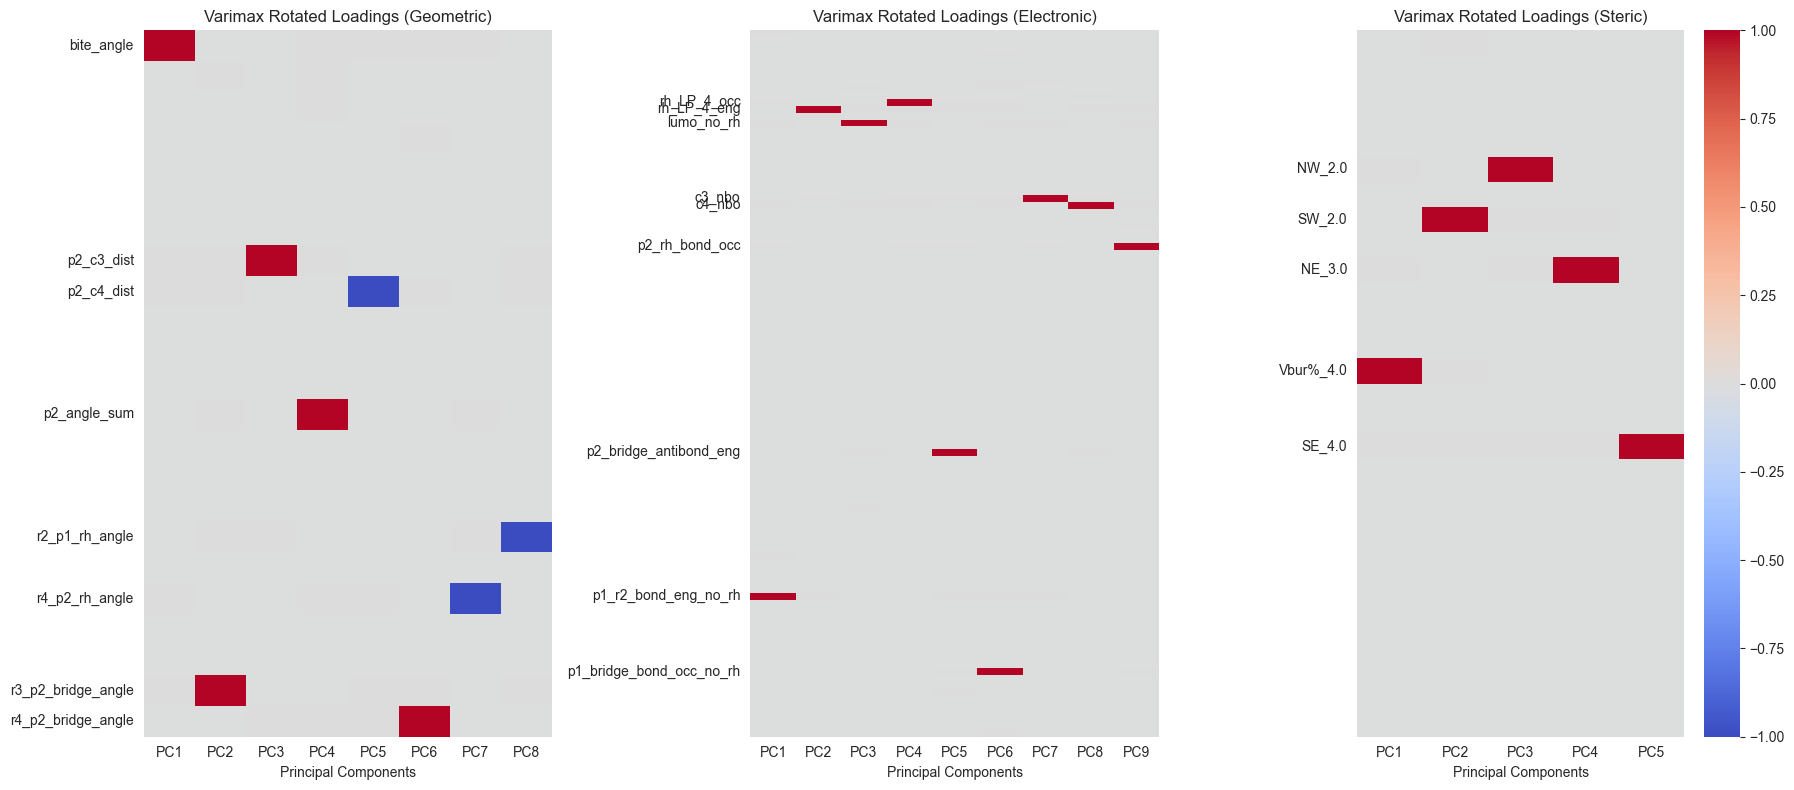

In [160]:
# Get the loadings for each PCA
loadings_geometric = pd.DataFrame(pca_geometric.components_, columns=geometric_df_final.columns, index=[f'PC{i+1}' for i in range(num_components_geometric)])
loadings_electronic = pd.DataFrame(pca_electronic.components_, columns=electronic_df_final.columns, index=[f'PC{i+1}' for i in range(num_components_electronic)])
loadings_steric = pd.DataFrame(pca_steric.components_, columns=steric_df_final.columns, index=[f'PC{i+1}' for i in range(num_components_steric)])

# Perform varimax rotation for each of the loadings
rotated_geometric = Rotator(method='varimax').fit_transform(loadings_geometric.values)
rotated_electronic = Rotator(method='varimax').fit_transform(loadings_electronic.values)
rotated_steric = Rotator(method='varimax').fit_transform(loadings_steric.values)

varimax_geometric = pd.DataFrame(rotated_geometric, columns=loadings_geometric.columns, index=loadings_geometric.index)
varimax_electronic = pd.DataFrame(rotated_electronic, columns=loadings_electronic.columns, index=loadings_electronic.index)
varimax_steric = pd.DataFrame(rotated_steric, columns=loadings_steric.columns, index=loadings_steric.index)

# Store the three DataFrames in a dictionary for easier iteration
varimax_dict = {
    "Geometric": varimax_geometric,
    "Electronic": varimax_electronic,
    "Steric": varimax_steric
}

# Define relevance threshold for displaying parameter labels
threshold = 0.4

# Determine the common color scale range
vmin = min(df.values.min() for df in varimax_dict.values())  # Minimum loading across all datasets
vmax = max(df.values.max() for df in varimax_dict.values())  # Maximum loading across all datasets

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=False)  # Separate y-axis labels for each heatmap

for ax, (title, df) in zip(axes, varimax_dict.items()):
    rotated_loadings = df.values  # Convert DataFrame to NumPy array
    param_names = df.columns      # Get parameter names
    num_pcs = rotated_loadings.shape[0]  # Number of PCs in this PCA

    # Identify relevant parameters based on highest absolute loading
    max_loadings = np.max(np.abs(rotated_loadings), axis=0)
    relevant_params = [name if max_loadings[i] > threshold else "" for i, name in enumerate(param_names)]

    # Transpose the matrix for correct orientation
    rotated_loadings_T = rotated_loadings.T  # Shape: (parameters, PCs)

    # Plot heatmap with common color scale
    sns.heatmap(rotated_loadings_T, cmap='coolwarm', center=0, annot=False, ax=ax,
                xticklabels=[f'PC{i+1}' for i in range(num_pcs)],
                yticklabels=relevant_params, vmin=vmin, vmax=vmax, cbar=(ax == axes[2]))

    # Formatting
    ax.set_xlabel('Principal Components')
    ax.set_title(f'Varimax Rotated Loadings ({title})')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

Accounted variance for each component of each PCA. We can see that, for the first PC, steric > electronic > geometric in terms of explained variance.

In [161]:
pca_geometric_trans = pca_geometric.transform(geometric_df_final)
pca_electronic_trans = pca_electronic.transform(electronic_df_final)
pca_steric_trans = pca_steric.transform(steric_df_final)

print(pca_geometric.explained_variance_ratio_)
print(pca_electronic.explained_variance_ratio_)
print(pca_steric.explained_variance_ratio_)

[0.22269736 0.11825332 0.10109051 0.08978492 0.08814585 0.07211962
 0.0659811  0.05492659]
[0.3265286  0.16710386 0.09872695 0.0649343  0.0578457  0.02996641
 0.02490447 0.02335386 0.02105797]
[0.4422316  0.12042607 0.10556263 0.08334452 0.07338588]


In [162]:
pca_results = pd.DataFrame({"ligand": data["ligand"],"geometric": pca_geometric_trans[:, 0], "electronic": pca_electronic_trans[:, 0], "steric": pca_steric_trans[:, 0]})
pca_results.to_csv("pca_results.csv", index=False)

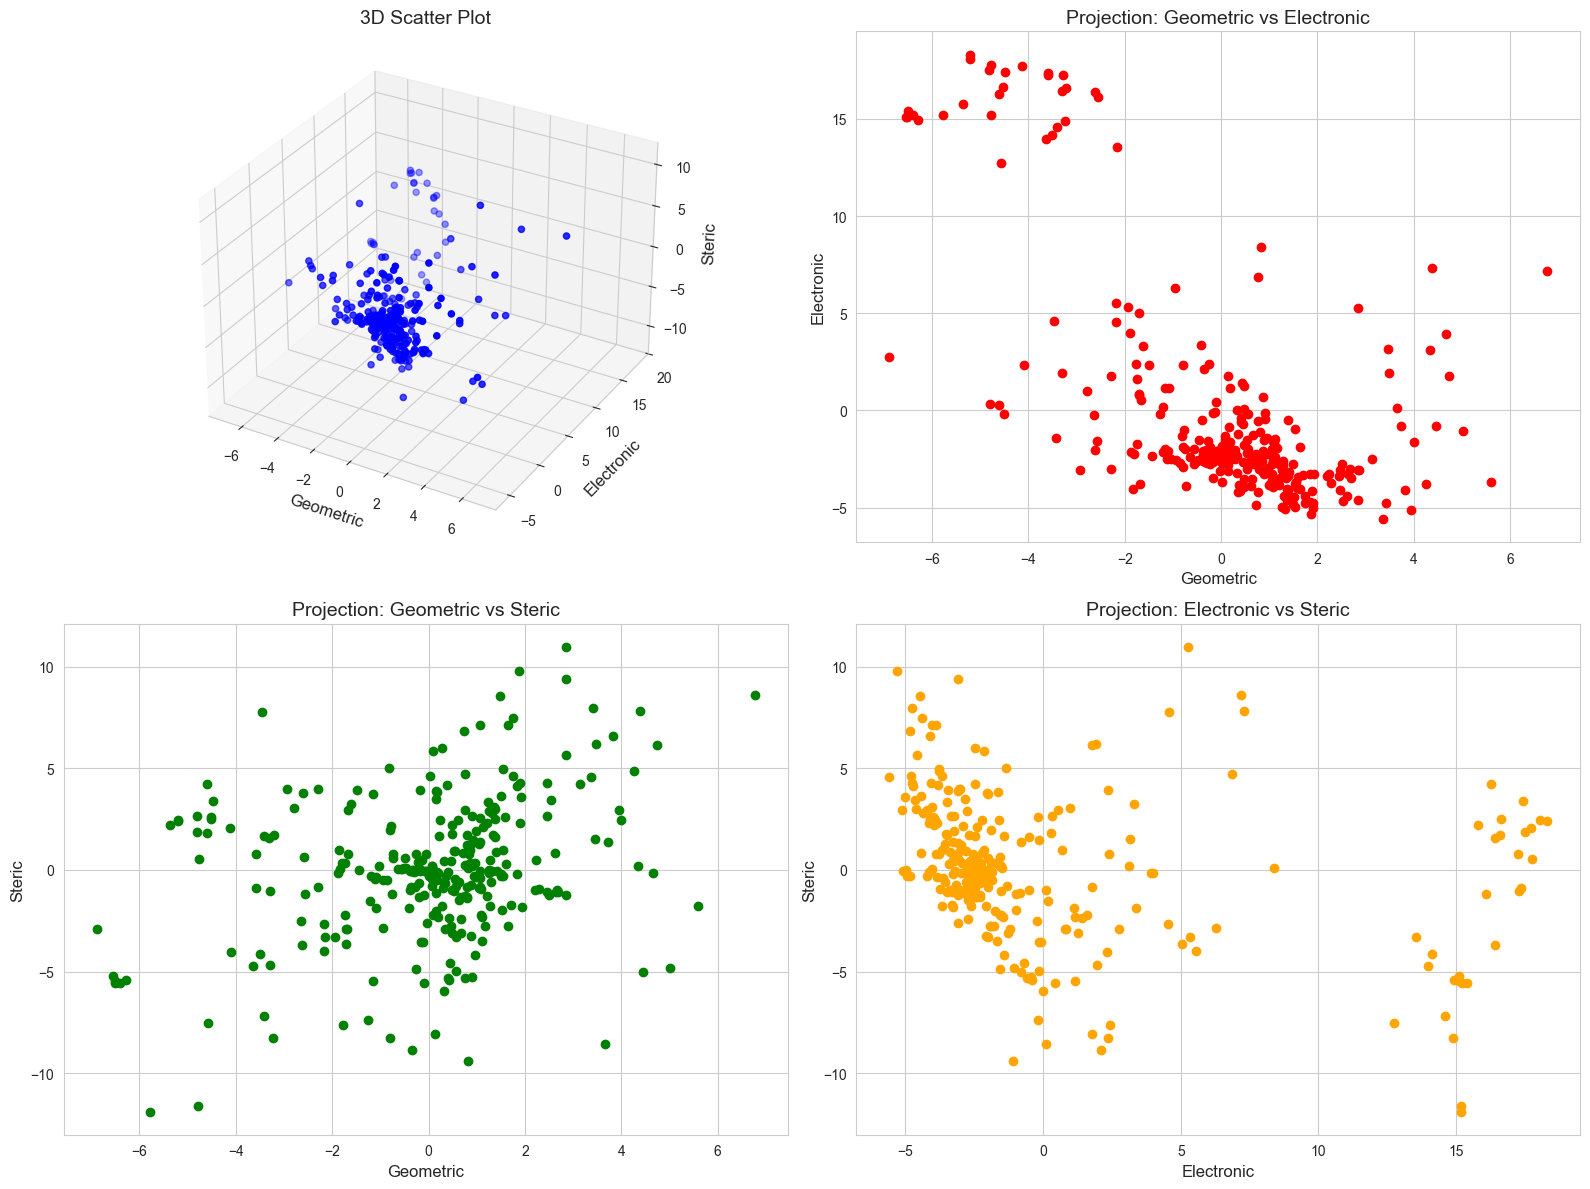

In [163]:
fig = plt.figure(figsize=(16, 12))

# 3D plot
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(
    pca_geometric_trans[:, 0],
    pca_electronic_trans[:, 0],
    pca_steric_trans[:, 0],
    c='b'
)
ax1.set_xlabel('Geometric', fontsize=12)
ax1.set_ylabel('Electronic', fontsize=12)
ax1.set_zlabel('Steric', fontsize=12)
ax1.set_title('3D Scatter Plot', fontsize=14)

# XY plane projection
ax2 = fig.add_subplot(222)
ax2.scatter(
    pca_geometric_trans[:, 0],
    pca_electronic_trans[:, 0],
    c='r'
)
ax2.set_xlabel('Geometric', fontsize=12)
ax2.set_ylabel('Electronic', fontsize=12)
ax2.set_title('Projection: Geometric vs Electronic', fontsize=14)

# XZ plane projection
ax3 = fig.add_subplot(223)
ax3.scatter(
    pca_geometric_trans[:, 0],
    pca_steric_trans[:, 0],
    c='g'
)
ax3.set_xlabel('Geometric', fontsize=12)
ax3.set_ylabel('Steric', fontsize=12)
ax3.set_title('Projection: Geometric vs Steric', fontsize=14)

# YZ plane projection
ax4 = fig.add_subplot(224)
ax4.scatter(
    pca_electronic_trans[:, 0],
    pca_steric_trans[:, 0],
    c='orange'
)
ax4.set_xlabel('Electronic', fontsize=12)
ax4.set_ylabel('Steric', fontsize=12)
ax4.set_title('Projection: Electronic vs Steric', fontsize=14)

plt.tight_layout()
plt.show()

# Clustering
k-means and DBSCAN are implemented, finding k-means the better option at `k = 5`. In this first cell, data is defined from the results of the chemical space plot.

In [164]:
# Load data
file_path = "pca_results.csv"  # Update with your actual file path
data = pd.read_csv(file_path)
X = data[['geometric', 'electronic', 'steric']].values

## k-means clustering
The first cell finds the optimum k value implementing the silhouette method. This finds the best silhouette score for `k = 2`. However, this makes no sense from a chemical standpoint.
Generating the elbow and silhouette plots shows that `k = 5` could be a good value. This value gives coherent clusters with some clearly differentiated areas.

In [165]:
param_grid = range(2, 11)  # Trying k from 2 to 10
best_k = None
best_score = -1

for k in param_grid:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best k: {best_k}, Best silhouette score: {best_score}")


Best k: 2, Best silhouette score: 0.7065050429491606


Silhouette Score for K-Means: 0.4285024482559641


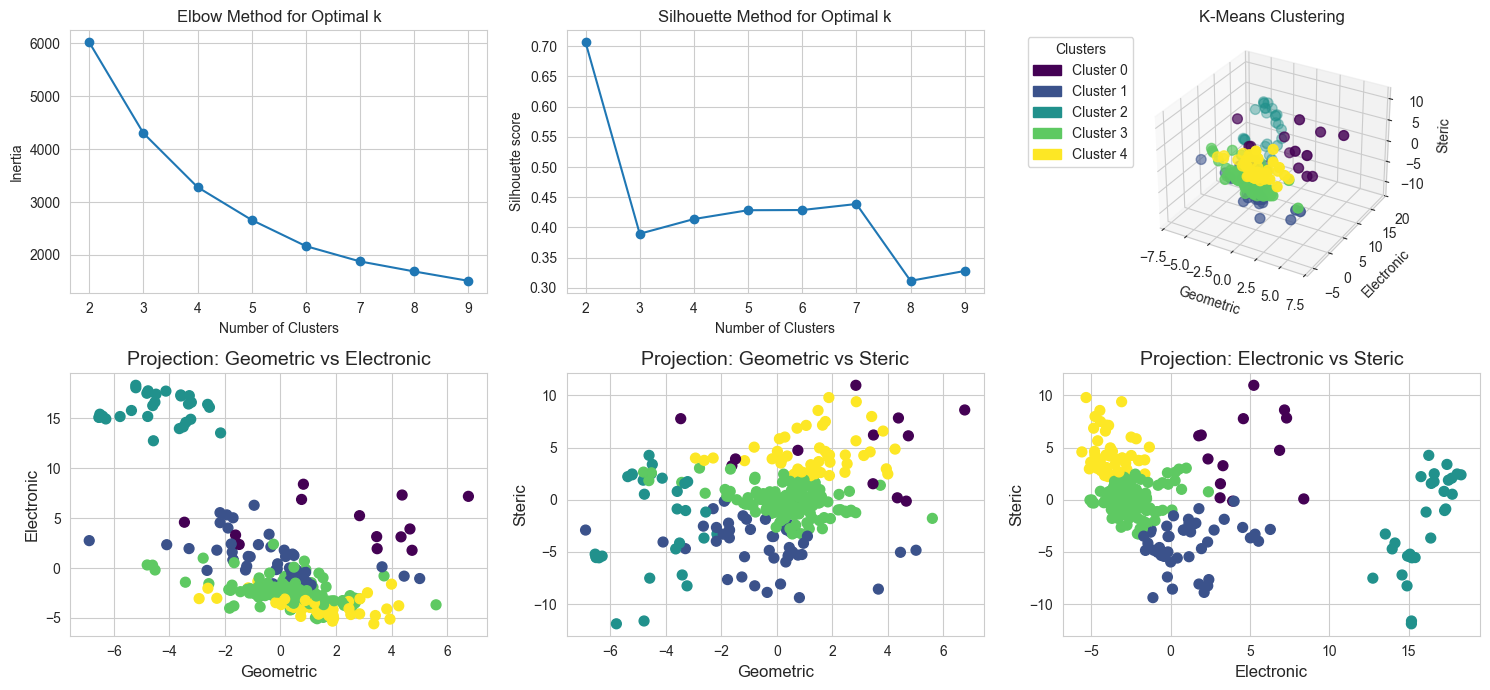

In [169]:
# K-Means Clustering with Elbow Method
inertia = []
silhouette = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    labels = kmeans.predict(X)
    silhouette.append(silhouette_score(X, labels))

fig = plt.figure(figsize=(15, 7))

# Plot Elbow Method
ax = fig.add_subplot(231)
ax.plot(k_range, inertia, marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method for Optimal k')

# Plot Silhouette Method
ax = fig.add_subplot(232)
ax.plot(k_range, silhouette, marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method for Optimal k')

# Fit K-Means with optimal k (adjust based on elbow method result)
k_optimal = 5 # Change based on elbow point
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# 3D Scatter Plot for K-Means
ax = fig.add_subplot(233, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=kmeans_labels, cmap='viridis', s=50)
ax.set_xlabel('Geometric')
ax.set_ylabel('Electronic')
ax.set_zlabel('Steric')
ax.set_title('K-Means Clustering')

unique_clusters = np.unique(kmeans_labels)
legend_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(cluster)),
                                 label=f'Cluster {cluster}') for cluster in unique_clusters]
ax.legend(handles=legend_patches, title="Clusters", bbox_to_anchor=(0, 1), loc='upper right')

# XY plane projection
ax2 = fig.add_subplot(234)
ax2.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=50)
ax2.set_xlabel('Geometric', fontsize=12)
ax2.set_ylabel('Electronic', fontsize=12)
ax2.set_title('Projection: Geometric vs Electronic', fontsize=14)

# XZ plane projection
ax3 = fig.add_subplot(235)
ax3.scatter(X[:, 0], X[:, 2], c=kmeans_labels, cmap='viridis', s=50)
ax3.set_xlabel('Geometric', fontsize=12)
ax3.set_ylabel('Steric', fontsize=12)
ax3.set_title('Projection: Geometric vs Steric', fontsize=14)

# YZ plane projection
ax4 = fig.add_subplot(236)
ax4.scatter(X[:, 1], X[:, 2], c=kmeans_labels, cmap='viridis', s=50)
ax4.set_xlabel('Electronic', fontsize=12)
ax4.set_ylabel('Steric', fontsize=12)
ax4.set_title('Projection: Electronic vs Steric', fontsize=14)

plt.tight_layout()

# Evaluate clustering
print("Silhouette Score for K-Means:", silhouette_score(X, kmeans_labels))

## DBSCAN clustering
This option provides a maximum of three clusters with the options I have tried. I think k-means is a better option for this application.
The first cell finds the optimal values for the DBSCAN, which are `eps = 1.4` and `min_samples = 7`. However, these values provide only two clusters with little chemical sense. I have found that `eps = 5` and `min_samples = 5` gives better results, although much worse than with k-means.

In [170]:
best_eps = None
best_min_samples = None
best_score = -1  # Higher silhouette score is better

for eps in np.arange(0.1, 1.5, 0.1):  # Try different eps values
    for min_samples in range(3, 10):  # Try different min_samples values
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = clustering.labels_

        if len(set(labels)) > 1 and -1 in labels:  # Ignore cases with no clusters
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Optimal eps: {best_eps}, Optimal min_samples: {best_min_samples}, Silhouette Score: {best_score}")

Optimal eps: 1.3000000000000003, Optimal min_samples: 6, Silhouette Score: 0.37666266894434597


Silhouette Score for DBSCAN: 0.37666266894434597


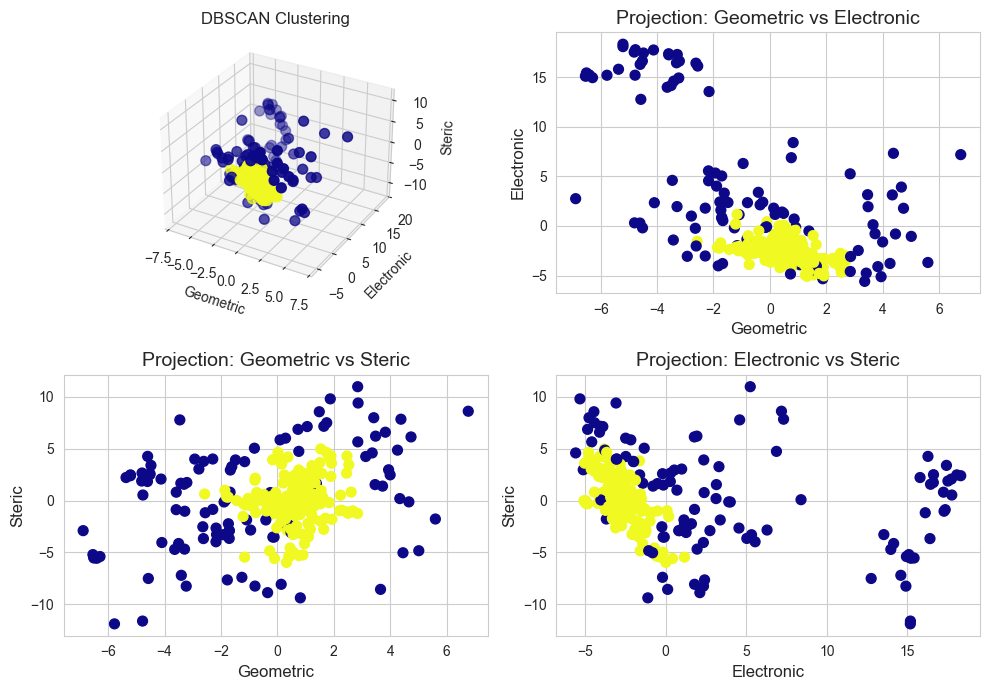

In [171]:
# Fit DBSCAN (adjust parameters for best clustering)
dbscan = DBSCAN(eps=1.3, min_samples=6)
dbscan_labels = dbscan.fit_predict(X)

fig = plt.figure(figsize=(10, 7))

# 3D Scatter Plot for DBSCAN
ax = fig.add_subplot(221, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=dbscan_labels, cmap='plasma', s=50)
ax.set_xlabel('Geometric')
ax.set_ylabel('Electronic')
ax.set_zlabel('Steric')
ax.set_title('DBSCAN Clustering')

# XY plane projection
ax2 = fig.add_subplot(222)
ax2.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='plasma', s=50)
ax2.set_xlabel('Geometric', fontsize=12)
ax2.set_ylabel('Electronic', fontsize=12)
ax2.set_title('Projection: Geometric vs Electronic', fontsize=14)

# XZ plane projection
ax3 = fig.add_subplot(223)
ax3.scatter(X[:, 0], X[:, 2], c=dbscan_labels, cmap='plasma', s=50)
ax3.set_xlabel('Geometric', fontsize=12)
ax3.set_ylabel('Steric', fontsize=12)
ax3.set_title('Projection: Geometric vs Steric', fontsize=14)

# YZ plane projection
ax4 = fig.add_subplot(224)
ax4.scatter(X[:, 1], X[:, 2], c=dbscan_labels, cmap='plasma', s=50)
ax4.set_xlabel('Electronic', fontsize=12)
ax4.set_ylabel('Steric', fontsize=12)
ax4.set_title('Projection: Electronic vs Steric', fontsize=14)

plt.tight_layout()

if len(set(dbscan_labels)) > 1:  # Check if DBSCAN found clusters
    print("Silhouette Score for DBSCAN:", silhouette_score(X, dbscan_labels))
else:
    print("DBSCAN did not find meaningful clusters. Try adjusting eps/min_samples.")

# Merging datasets
The results from the chemical space plot are merged with the dataframe containing the structures from the ligands created from an SDFile. The cluster of each ligand is also included.

In [172]:
data["kmeans"] = kmeans_labels
data["dbscan"] = dbscan_labels

[12:14:12] atom 9 has specified valence (4) smaller than the drawn valence 5.
[12:14:12] Skipping unrecognized collection type at line 15870: MDLV30/STERAC1 BONDS=(1 31)
[12:14:12] Skipping unrecognized collection type at line 18594: MDLV30/STERAC1 BONDS=(1 33)
[12:14:12] Skipping unrecognized collection type at line 26043: MDLV30/STERAC1 BONDS=(1 37)
[12:14:12] Skipping unrecognized collection type at line 26175: MDLV30/STERAC1 BONDS=(1 37)
[12:14:12] Skipping unrecognized collection type at line 30775: MDLV30/STERAC1 BONDS=(1 45)
[12:14:12] Skipping unrecognized collection type at line 32283: MDLV30/STERAC1 BONDS=(1 51)


,Molecule Name,cas.rn,molecular.formula,molecular.weight,Dataset Name,Link,Ref 2,BBDD,CSD,Code,Calculations,cas.index.name,ID,ROMol
0,"1,1′-Methylenebis[1,1-dimethylphosphine]",64065-08-3,C5H14P2,136.11,methylene bridge,,211 results,,"58 structures\nIr, Ru, Mo, Fe, Ni, Re, Co, W, ...",MB-1,"Opt, SPE, NoRh",,"1,1′-Methylenebis[1,1-dimethylphosphine]",
1,"Phosphine, ethylidenebis[dimethyl-",95837-98-2,C6H16P2,150.14,monosubstituted C-bridge,https://www.degruyter.com/document/doi/10.1515...,"Zeitschrift fuer Naturforschung, Teil B: Anorg...",,0 structures,MB-2,"Opt, SPE, NoRh",,"Phosphine, ethylidenebis[dimethyl-",
2,"1,1-Bis(dimethylphosphino)-N,N-dimethylmethana...",40207-88-3,C7H19NP2,179.18,substituted bridge,https://www.sciencedirect.com/science/article/...,"Journal of Organometallic Chemistry (1972), 46...",,0 structures,MS-70,"Opt, SPE, NoRh","Methanamine, 1,1-bis(dimethylphosphino)-N,N-di...","1,1-Bis(dimethylphosphino)-N,N-dimethylmethana...",
3,"2,2′-Methylenebis[1,3,2-dioxaphospholane]",129195-14-8,C5H10O4P2,196.08,methylene bridge,https://pubs.acs.org/doi/abs/10.1021/ic00344a049,"Inorg. Chem. 1990, 29, 19, 3896–3898",,0 structures,MB-3,"Opt, SPE, NoRh",,"2,2′-Methylenebis[1,3,2-dioxaphospholane]",
4,[[Bis(1-methylethyl)phosphino]methyl]dimethylp...,905831-48-3,C9H22P2,192.22,methylene bridge,https://www.thieme-connect.de/products/ebooks/...,"Inorganica Chimica Acta (2006), 359(10), 3191-...",,YELNEJ (Ni),MB-4,"Opt, SPE, NoRh",,[[Bis(1-methylethyl)phosphino]methyl]dimethylp...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,,,,,methylene bridge,,,,,phPAMP,"Opt, SPE, NoRh",,,
299,,,,,methylene bridge,,,,,cyPAMP,"Opt, SPE, NoRh",,,
300,,,,,NH-bridge,,,,,dcpa,"Opt, SPE, NoRh",,,
301,,,,,NH-bridge,,,,,diprpa,"Opt, SPE, NoRh",,,

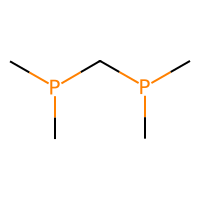
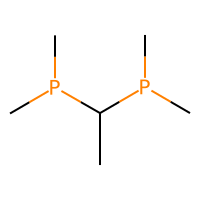
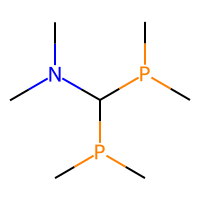
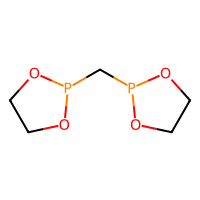
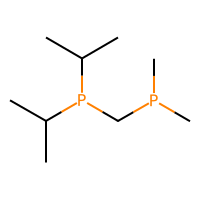
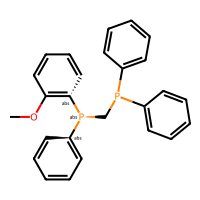
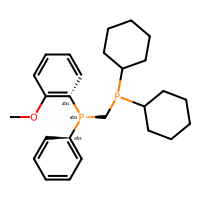
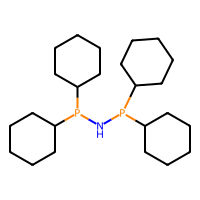
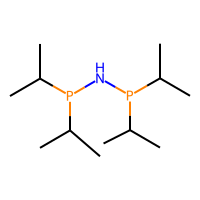
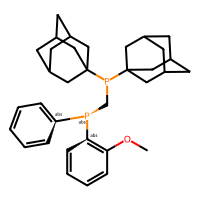

In [173]:
sdf_file = "C-bridge_selected.sdf"
df = PandasTools.LoadSDF(sdf_file, sanitize=False)

df

In [174]:
merged_df = pd.merge(df, data, left_on='Code', right_on="ligand", how='inner')
merged_df

,Molecule Name,cas.rn,molecular.formula,molecular.weight,Dataset Name,Link,Ref 2,BBDD,CSD,Code,Calculations,cas.index.name,ID,ROMol,ligand,geometric,electronic,steric,kmeans,dbscan
0,"1,1′-Methylenebis[1,1-dimethylphosphine]",64065-08-3,C5H14P2,136.11,methylene bridge,,211 results,,"58 structures\nIr, Ru, Mo, Fe, Ni, Re, Co, W, ...",MB-1,"Opt, SPE, NoRh",,"1,1′-Methylenebis[1,1-dimethylphosphine]",<rdkit.Chem.rdchem.Mol object at 0x00000163EDB...,MB-1,-0.346934,2.117501,-8.874603,1,-1
1,"Phosphine, ethylidenebis[dimethyl-",95837-98-2,C6H16P2,150.14,monosubstituted C-bridge,https://www.degruyter.com/document/doi/10.1515...,"Zeitschrift fuer Naturforschung, Teil B: Anorg...",,0 structures,MB-2,"Opt, SPE, NoRh",,"Phosphine, ethylidenebis[dimethyl-",<rdkit.Chem.rdchem.Mol object at 0x00000163EDC...,MB-2,-0.794663,2.343746,-8.244238,1,-1
2,"1,1-Bis(dimethylphosphino)-N,N-dimethylmethana...",40207-88-3,C7H19NP2,179.18,substituted bridge,https://www.sciencedirect.com/science/article/...,"Journal of Organometallic Chemistry (1972), 46...",,0 structures,MS-70,"Opt, SPE, NoRh","Methanamine, 1,1-bis(dimethylphosphino)-N,N-di...","1,1-Bis(dimethylphosphino)-N,N-dimethylmethana...",<rdkit.Chem.rdchem.Mol object at 0x00000163EDC...,MS-70,-1.774446,2.411668,-7.647644,1,-1
3,"2,2′-Methylenebis[1,3,2-dioxaphospholane]",129195-14-8,C5H10O4P2,196.08,methylene bridge,https://pubs.acs.org/doi/abs/10.1021/ic00344a049,"Inorg. Chem. 1990, 29, 19, 3896–3898",,0 structures,MB-3,"Opt, SPE, NoRh",,"2,2′-Methylenebis[1,3,2-dioxaphospholane]",<rdkit.Chem.rdchem.Mol object at 0x00000163F18...,MB-3,-4.779512,15.183065,-11.613142,2,-1
4,[[Bis(1-methylethyl)phosphino]methyl]dimethylp...,905831-48-3,C9H22P2,192.22,methylene bridge,https://www.thieme-connect.de/products/ebooks/...,"Inorganica Chimica Acta (2006), 359(10), 3191-...",,YELNEJ (Ni),MB-4,"Opt, SPE, NoRh",,[[Bis(1-methylethyl)phosphino]methyl]dimethylp...,<rdkit.Chem.rdchem.Mol object at 0x00000163F11...,MB-4,-0.117051,-0.090429,-3.521500,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,,,,,methylene bridge,,,,,phPAMP,"Opt, SPE, NoRh",,,<rdkit.Chem.rdchem.Mol object at 0x00000163F19...,phPAMP,1.290481,-2.804517,-0.574274,3,0
290,,,,,methylene bridge,,,,,cyPAMP,"Opt, SPE, NoRh",,,<rdkit.Chem.rdchem.Mol object at 0x00000163F19...,cyPAMP,1.838363,-3.287789,-0.205470,3,0
291,,,,,NH-bridge,,,,,dcpa,"Opt, SPE, NoRh",,,<rdkit.Chem.rdchem.Mol object at 0x00000163F19...,dcpa,3.995996,-1.616237,2.469542,4,-1
292,,,,,NH-bridge,,,,,diprpa,"Opt, SPE, NoRh",,,<rdkit.Chem.rdchem.Mol object at 0x00000163F19...,diprpa,3.727472,-0.789333,1.385807,3,-1


This cell gets the min, max, and centerpoint of an axis and plots the three molecules. Useful for seeing the extremes of each axis to see if it matches with the chemical interpretation (e.g., if in the steric axis the ligand with the lowest value is the smallest and the one with the highest the bulkiest).

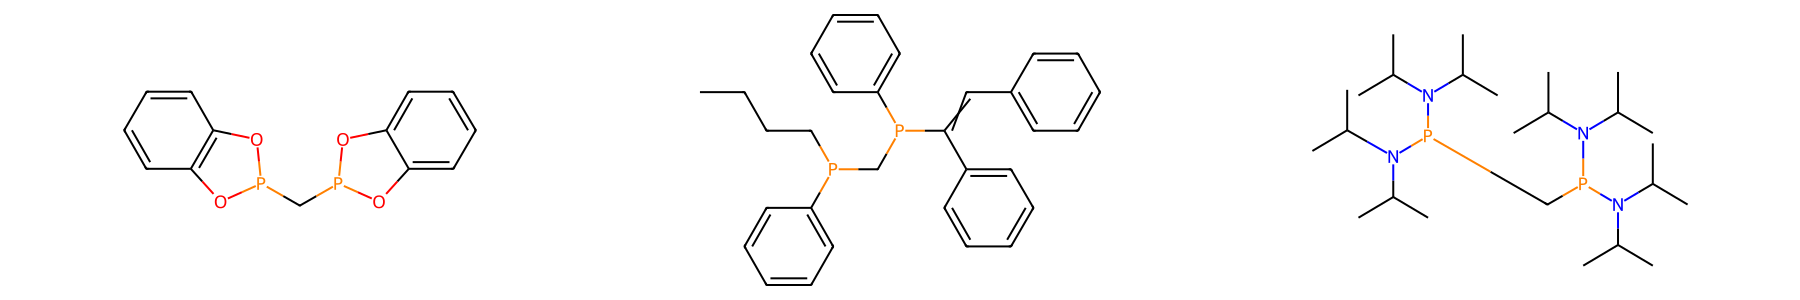

In [175]:
# Step 1: Get min, center, and max points
geometric_values = merged_df['steric']
min_value = geometric_values.min()
max_value = geometric_values.max()
center_value = geometric_values.median()

# Step 2: Identify molecules corresponding to these values
min_molecule = merged_df.loc[geometric_values.idxmin(), 'ROMol']
max_molecule = merged_df.loc[geometric_values.idxmax(), 'ROMol']

# Find the index of the value closest to the median
center_index = (geometric_values - center_value).abs().idxmin()
center_molecule = merged_df.loc[center_index, 'ROMol']

# Draw the molecules
molecules = [min_molecule, center_molecule, max_molecule]
Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(600, 300))


This cell shows the structures of each group by changing the method (kmeans or dbscan) and group (i.e. cluster) variables.

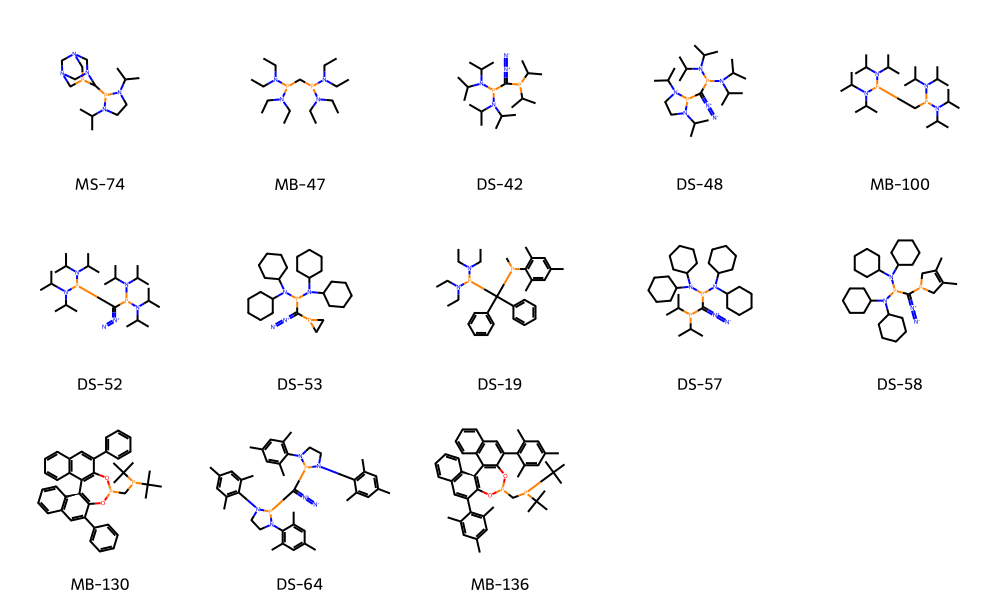

In [181]:
method = "kmeans"
group = 0
molecules = merged_df[merged_df[method] == group]['ROMol'].tolist()
names = merged_df[merged_df[method] == group]['ligand'].tolist()

Draw.MolsToGridImage(molecules, molsPerRow=5, maxMols=300, legends=names, subImgSize=(200,200))

# KNN
Implementation and plotting to find the k-Nearest Neighbors of a specified ligand. k has been set to 5.

In [182]:
k = 5
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
nearest_distances = distances[:, 1:]
print("Distances to nearest neighbors:\n", nearest_distances[:5])

Distances to nearest neighbors:
 [[0.46380031 0.58429511 0.62037403 0.66468935 0.81837792]
 [0.65373248 0.68599651 0.69004499 0.72567099 0.81538465]
 [1.3893727  2.14854901 2.32942998 2.9572539  2.99927896]
 [1.3893727  2.37268531 2.8886829  3.0169721  3.12309418]
 [0.23567822 0.37413912 0.410799   0.47040022 0.47633598]]


Nearest neighbors of point 1: [178 189 115 163 161]


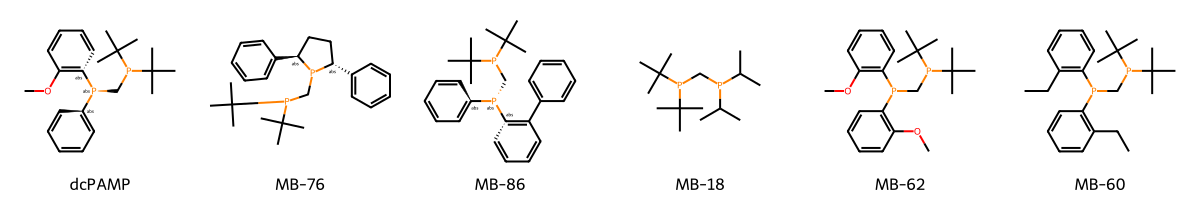

In [183]:
ligand_name = "dcPAMP"
point_idx = data[data["ligand"] == ligand_name].index[0]
nearest_neighbors_indices = indices[point_idx, 1:k+1]
nearest_neighbors = X[nearest_neighbors_indices]

# Print nearest neighbor indices
print(f"Nearest neighbors of point {point_idx}: {nearest_neighbors_indices}")

insert = np.insert(nearest_neighbors_indices, 0, point_idx, axis=0)
nearest_ligands = data.loc[insert]["ligand"]
nearest_ligands_df = merged_df[merged_df["ligand"].isin(nearest_ligands)]
nearest_ligands_df = nearest_ligands_df.set_index("ligand")
nearest_ligands_df = nearest_ligands_df.loc[nearest_ligands]
nearest_ligands_df = nearest_ligands_df.reset_index()

# The first compound is the ligand from which we are computing the NN.
Draw.MolsToGridImage(nearest_ligands_df["ROMol"], molsPerRow=6, maxMols=300, legends=nearest_ligands_df["ligand"].tolist())

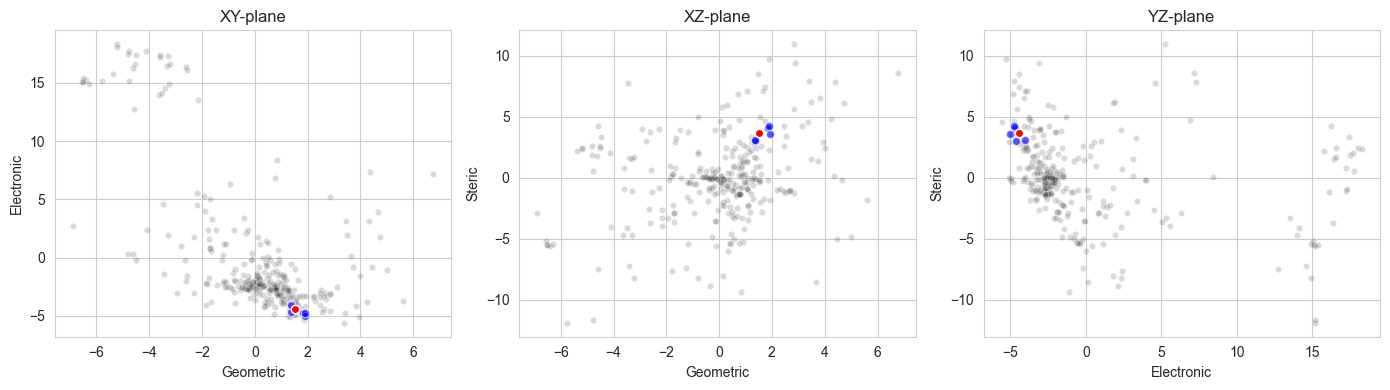

In [184]:
fig = plt.figure(figsize=(14, 4))

projections = [(0, 1, "XY-plane"), (0, 2, "XZ-plane"), (1, 2, "YZ-plane")]
axis_labels = ["Geometric", "Electronic", "Steric"]
for i, (dim1, dim2, title) in enumerate(projections, start=1):
    ax = fig.add_subplot(1, 3, i)

    # Plot all points
    ax.scatter(X[:, dim1], X[:, dim2], c="k", alpha=0.15, edgecolor='w', s=20, label="All Points")

    # Highlight the selected point
    ax.scatter(X[point_idx, dim1], X[point_idx, dim2], c="red", edgecolor='w', label="Selected Point", zorder=50)

    # Highlight nearest neighbors
    ax.scatter(nearest_neighbors[:, dim1], nearest_neighbors[:, dim2], c="blue", edgecolor='w', label="Nearest Neighbors", alpha=0.6)

    ax.set_xlabel(axis_labels[dim1])
    ax.set_ylabel(axis_labels[dim2])
    ax.set_title(title)

plt.tight_layout()
plt.show()